### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2, glob

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

### Define some preprocessing functions

In [2]:
def extract_n_images(images, labels, n=25):

    '''Extracts n_images images from each class in the dataset.'''
    
    out_images, out_labels = [], []

    # Get the unique classes
    unique_labels = np.unique(labels)

    # Sample n images from each class
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        np.random.shuffle(indices)
        indices = indices[:n]
        out_images.append(images[indices])
        out_labels.append(labels[indices])
    
    # Convert to numpy arrays
    out_images = np.concatenate(out_images, axis=0)  # (n_classes*n_images, h, w, c)
    out_labels = np.concatenate(out_labels, axis=0)  # (n_classes*n_images,)
    
    return out_images, out_labels

In [3]:
def resize_and_grayscale(images, size=(75, 100)):
    
    '''Resizes and converts image to grayscale.'''
    
    out_images = []
    
    # Resize and convert to grayscale
    for image in images:
        image = cv2.resize(image, size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        out_images.append(image)
    
    return np.array(out_images)

In [4]:
def print_dataset_info(images, labels):

    '''Prints information about the dataset.'''

    print(f'- Number of classes\t: {len(np.unique(labels))} ({np.unique(labels).min()} - {np.unique(labels).max()})')
    print(f'- Number of images\t: {images.shape[0]}')
    print(f'- Image size\t\t: {images.shape[1]} x {images.shape[2]}')
    print(f'- Image channels\t: {images.shape[3] if images.ndim == 4 else 1}')
    print(f'- Image value range\t: {images.min()} - {images.max()}')
    print(f'- Image dtype\t\t: {images.dtype}')

### Our dataset

In [5]:
members = ['honey', 'jane', 'philip', 'veronica', 'wai_yeong']
our_images, our_labels = [], []

# Create our dataset
for i, member in enumerate(members):
    for path in glob.glob(f'output/{member}/*.png'):
        our_images.append(cv2.imread(path))
        our_labels.append(i)

our_images = np.array(our_images)
our_labels = np.array(our_labels)

print('Our dataset before preprocessing')
print_dataset_info(our_images, our_labels)

Our dataset before preprocessing
- Number of classes	: 5 (0 - 4)
- Number of images	: 200
- Image size		: 100 x 75
- Image channels	: 3
- Image value range	: 0 - 255
- Image dtype		: uint8


In [6]:
# Convert BGR to RGB, then normalise to [0, 1]
our_images = (our_images[..., ::-1] / 255.0).astype('float32')

# Resize and convert to grayscale
our_images = resize_and_grayscale(our_images, size=(75, 100))

print('Our dataset after preprocessing')
print_dataset_info(our_images, our_labels)

Our dataset after preprocessing
- Number of classes	: 5 (0 - 4)
- Number of images	: 200
- Image size		: 100 x 75
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


### LFW dataset 

In [10]:
# Set random seed for reproducibility
np.random.seed(0)

# Load the LFW dataset and extract 25 random images from each class
lfw_people = fetch_lfw_people(min_faces_per_person=40, color=True, resize=1.0)
lfw_images, lfw_labels = extract_n_images(lfw_people.images, lfw_people.target, n=40)

# Offset the labels by 5 to avoid conflict with our dataset
lfw_labels = lfw_labels + len(members)

print('LFW dataset before preprocessing')
print_dataset_info(lfw_images, lfw_labels)

OSError: image file is truncated (112 bytes not processed)

In [8]:
# Resize and convert to grayscale
lfw_images = resize_and_grayscale(lfw_images, size=(75, 100))

print('LFW dataset after preprocessing')
print_dataset_info(lfw_images, lfw_labels)

NameError: name 'lfw_images' is not defined

### Combine both datasets

In [9]:
# Combine the LFW and our datasets
# images = np.concatenate([our_images, lfw_images], axis=0)
# labels = np.concatenate([our_labels, lfw_labels], axis=0)

images = np.concatenate([our_images], axis=0)
labels = np.concatenate([our_labels], axis=0)

print('Combined dataset')
print_dataset_info(images, labels)

Combined dataset
- Number of classes	: 5 (0 - 4)
- Number of images	: 200
- Image size		: 100 x 75
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


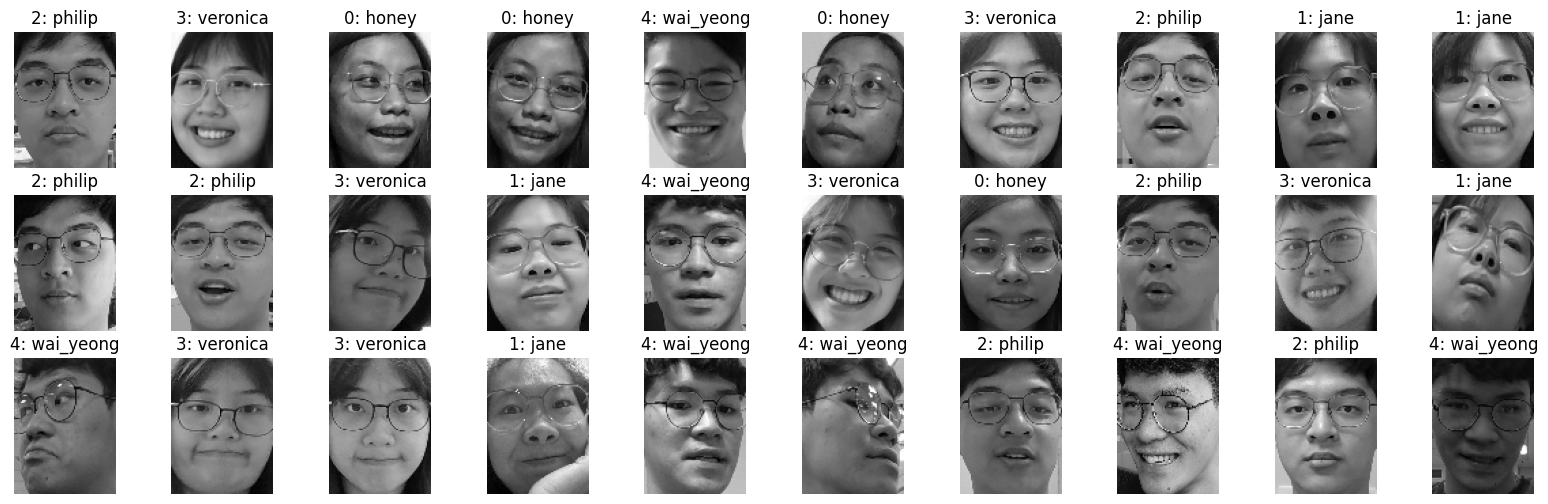

Note: Our members are labelled 0-4 and explicitly shown in the title.


In [11]:
def plot_images(images, labels, n=(5, 5)):

    '''Plots n random images from the dataset.'''
    
    # Randomly sample n images
    indices = np.random.choice(images.shape[0], size=n[0]*n[1], replace=False)
    images = images[indices]
    labels = labels[indices]

    # Plot the images
    plt.figure(figsize=(2*n[0], 2*n[1]), facecolor='white')
    for i in range(n[0]):
        for j in range(n[1]):
            index = i * n[1] + j
            plt.subplot(n[1], n[0], index+1)
            plt.imshow(images[index], cmap='gray')
            if labels[index] < len(members):
                plt.title(f'{labels[index]}: {members[labels[index]]}')
            else:
                plt.title(labels[index])
            plt.axis('off')
    plt.show()

# Set random seed for reproducibility
np.random.seed(7)
plot_images(images, labels, n=(10, 3))

print('Note: Our members are labelled 0-4 and explicitly shown in the title.')

In [ ]:
# Convert the images to feature vectors
images = images.reshape(images.shape[0], -1)

# Save the images and labels to disk
np.savez_compressed('artifacts/combined_dataset.npz', images=images, labels=labels)

### Perform train test split

You may use the preprocessed dataset saved earlier.

In [12]:
# Load the dataset from disk
dataset = np.load('artifacts/combined_dataset.npz')
images, labels = dataset['images'], dataset['labels']

# Save some variables for later use
n_classes = len(np.unique(labels))
n_images = images.shape[0]

print('n_classes:', n_classes)
print('n_images:', n_images)

n_classes: 5
n_images: 200


In [31]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.6, stratify=labels, random_state=0)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (120, 7500)
X_test: (80, 7500)
y_train: (120,)
y_test: (80,)


In [32]:
# Preview the image counts

df_counts = pd.DataFrame({
    'subject_id': np.arange(n_classes),
    'train': np.unique(y_train, return_counts=True)[1],
    'test': np.unique(y_test, return_counts=True)[1],
    'total': np.unique(labels, return_counts=True)[1]
})

print('Image counts')
df_counts.set_index('subject_id').T

Image counts


subject_id,0,1,2,3,4
train,24,24,24,24,24
test,16,16,16,16,16
total,40,40,40,40,40


### PCA

In [33]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.spatial.distance import mahalanobis, euclidean
from sklearn.metrics import accuracy_score

import joblib

In [34]:
n_components = 60

# PCA from sklearn
sk_pca = PCA(n_components=n_components, svd_solver='full')
X_train_pca = sk_pca.fit_transform(X_train)
X_test_pca = sk_pca.transform(X_test)

mu_fj = []

for i in range(n_classes):
    subject_indices = np.where(y_train==i)[0]
    mu_fj.append(np.mean(X_train_pca[subject_indices], axis=0))

mu_fj = np.array(mu_fj)

In [35]:
joblib.dump(sk_pca, 'artifacts/sk_pca_nclass_5.joblib')
np.savez_compressed('artifacts/mu_fj_nclass_5.npz', mu_fj=mu_fj)

KERAS - DEEP LEARNING

In [38]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout

from keras import regularizers

In [39]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

print(y_train.shape)
print(y_test.shape)

(120, 5)
(80, 5)


In [42]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=60))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(n_classes, activation='softmax'))

epochs = 100
batch_size = 128
red_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               15616     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                

In [43]:
history = model.fit(X_train_pca, y_train, epochs=epochs, validation_data=(X_test_pca,y_test), batch_size=128, verbose=1)

Epoch 1/100
1/1 [==============================] - 0s 164ms/step - loss: 1.7529 - accuracy: 0.2083 - val_loss: 1.4230 - val_accuracy: 0.4250
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 1.4829 - accuracy: 0.3500 - val_loss: 1.3049 - val_accuracy: 0.5875
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 1.3316 - accuracy: 0.4833 - val_loss: 1.2084 - val_accuracy: 0.6250
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 1.1177 - accuracy: 0.6333 - val_loss: 1.1218 - val_accuracy: 0.6750
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 0.9962 - accuracy: 0.6583 - val_loss: 1.0437 - val_accuracy: 0.7000
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 0.9698 - accuracy: 0.7167 - val_loss: 0.9748 - val_accuracy: 0.7125
Epoch 7/100
1/1 [==============================] - 0s 20ms/step - loss: 0.7802 - accuracy: 0.8000 - val_loss: 0.9111 - val_accuracy: 0.7250
Epoch 8/100
1/1 [==

MAHALOBIS DISTANCE

In [ ]:

# train_indices = np.where(y_train < 5)[0]
# test_indices = np.where(y_test < 5)[0]

# X_train_pca = X_train_pca[train_indices]
# X_test_pca = X_test_pca[test_indices]
# y_train = y_train[train_indices]
# y_test = y_test[test_indices]
# mu_fj = mu_fj[:5]

# X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape, mu_fj.shape

In [49]:
inv_pooled_covar = np.diag(1 / sk_pca.explained_variance_[:n_components])

y_train_preds, y_test_preds = [], []

for i in range(len(X_train_pca)):

    dist = np.array([mahalanobis(X_train_pca[i], mu_fj[j], inv_pooled_covar) for j in range(n_classes)])
    # dist = np.array([euclidean(X_train_pca[i], mu_fj[j]) for j in range(n_classes)])
    y_train_preds.append(np.argmin(dist))

for i in range(len(X_test_pca)):

    dist = np.array([mahalanobis(X_test_pca[i], mu_fj[j], inv_pooled_covar) for j in range(n_classes)])
    # dist = np.array([euclidean(X_test_pca[i], mu_fj[j]) for j in range(n_classes)])
    y_test_preds.append(np.argmin(dist))

accuracy_score(y_train_preds, y_train), accuracy_score(y_test_preds, y_test)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
sk_lda = LinearDiscriminantAnalysis(solver='svd')
X_train_lda = sk_lda.fit_transform(X_train_pca, y_train)
X_test_lda = sk_lda.transform(X_test_pca)

# mu_fj = []

# for i in range(n_classes):
#     subject_indices = np.where(y_train==i)[0]
#     mu_fj.append(np.mean(X_train_lda[subject_indices], axis=0))

accuracy_score(sk_lda.predict(X_train_pca), y_train), accuracy_score(sk_lda.predict(X_test_pca), y_test)

In [ ]:
indices = np.where(y_test < 5)[0]
accuracy_score(sk_lda.predict(X_test_pca)[indices], y_test[indices])

In [26]:
pca = joblib.load('artifacts/sk_pca_nclass_5.joblib')
pca.transform(X_test)

array([[ 2.0226331e+00,  7.4660192e+00, -9.2963624e-01, ...,
        -1.0784921e-01,  3.9946812e-01,  4.7466838e-01],
       [ 1.4269340e+00,  7.3497791e+00,  3.4824121e-01, ...,
        -7.3168725e-02, -2.5359884e-02, -6.6916341e-01],
       [-1.8117836e+00,  5.6815748e+00, -1.7214208e+00, ...,
        -2.3120949e-01, -1.6202649e-01, -8.9239337e-02],
       ...,
       [-2.0397222e+00, -3.2912579e+00,  1.8232845e+00, ...,
        -2.5082272e-01, -1.5488060e-01, -2.6382422e-01],
       [-1.0292383e+01, -2.7132075e+00, -1.9251765e+00, ...,
         5.9865183e-01, -7.7713832e-02, -4.7406235e-01],
       [ 3.3521041e-02, -3.7238951e+00,  2.6065319e+00, ...,
         2.3597234e-01, -1.2812337e-01,  9.8614618e-03]], dtype=float32)

In [52]:
model.predict_classes(X_test_pca)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([2, 4, 4, 0, 4, 3, 2, 2, 3, 2, 1, 3, 2, 4, 0, 0, 3, 1, 0, 3, 4, 1,
       3, 0, 0, 4, 4, 2, 1, 2, 3, 1, 1, 3, 1, 0, 1, 4, 4, 3, 2, 0, 2, 4,
       0, 4, 4, 0, 4, 2, 4, 0, 1, 1, 3, 1, 0, 2, 4, 1, 4, 1, 0, 4, 1, 4,
       0, 1, 2, 3, 0, 3, 2, 4, 1, 2, 1, 3, 0, 3], dtype=int64)

In [59]:
model.save('artifacts')

INFO:tensorflow:Assets written to: artifacts\assets
